The data has been taken from 10X.

# Preprocessing script to annotate cell types using CITE-seq and RNA-seq data used as ground truth

1. In this script, we normalize and preprocess each modality
2. Perform leiden clustering on each modality as well as multiplex leiden (from muon package)
3. Ground truth labels from BREM-SC were also added to mdata based on their pipeline. https://github.com/tarot0410/BREMSC/tree/master

In [1]:
import os
import sys
import datetime
import pandas as pd
import numpy as np
import scanpy as sc
import muon as mu
mu.set_options(pull_on_update=False)

2025-08-26 14:23:44.990103: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-26 14:23:45.046750: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-26 14:23:48.442990: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
sys.path.insert(0, '/scratch/g/tgu/svenkatesan/Other/SCREAM_wf')
import SCREAM

## Define directories

In [3]:
mainDir = '/scratch/g/tgu/svenkatesan/Other/SCREAM_wf'
inputDir = os.path.join(mainDir, 'inputfiles')
rawDir = os.path.join(inputDir, 'raw')
processedDir = os.path.join(inputDir, 'processed')
results_dir = os.path.join(mainDir, 'results')

## Define global settings

In [4]:
sc.set_figure_params(dpi=100, color_map='viridis_r')
%matplotlib inline

In [5]:
print(f'Time before running script: {datetime.datetime.now().strftime("%d %b %Y %H:%M:%S")}')
t_start = datetime.datetime.now()

Time before running script: 26 Aug 2025 14:23:50


## Read data

### Read 10X data

In [6]:
mdata = mu.read_10x_h5(os.path.join(rawDir, '10x_pbmc_10k_protein', 'pbmc_10k_protein_v3_filtered_feature_bc_matrix.h5'))
mdata_raw = mu.read_10x_h5(os.path.join(rawDir, '10x_pbmc_10k_protein', 'pbmc_10k_protein_v3_raw_feature_bc_matrix.h5'))

/home/svenkatesan/.conda/envs/Shri_NN/lib/python3.12/site-packages/anndata/_core/anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/svenkatesan/.conda/envs/Shri_NN/lib/python3.12/site-packages/anndata/_core/anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/svenkatesan/.conda/envs/Shri_NN/lib/python3.12/site-packages/mudata/_core/mudata.py:616: UserWarning: var_names are not unique. To make them unique, call `.var_names_make_unique`.
  warnings.warn(
/home/svenkatesan/.conda/envs/Shri_NN/lib/python3.12/site-packages/anndata/_core/anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/svenkatesan/.conda/envs/Shri_NN/lib/python3.12/site-packages/anndata/_core/anndata.py:1793: UserWa

In [7]:
truth_pd = pd.read_csv(os.path.join(rawDir, '10x_pbmc_10k_protein', 'truth_10X10k.csv')).set_index('Barcode')  # Taken from BREM-SC
mdata.obs = mdata.obs.join(truth_pd, how='left')

In [8]:
mdata.mod['rna'].var = mdata.mod['rna'].var.reset_index(names='entrezgene_symbol').set_index('gene_ids')
mdata.mod['prot'].var = mdata.mod['prot'].var.reset_index(names='feature_name').set_index('gene_ids')
mdata.update()

mdata_raw.mod['rna'].var = mdata_raw.mod['rna'].var.reset_index(names='entrezgene_symbol').set_index('gene_ids')
mdata_raw.mod['prot'].var = mdata_raw.mod['prot'].var.reset_index(names='feature_name').set_index('gene_ids')
mdata_raw.update()

In [9]:
prot = mdata.mod['prot']
prot.layers['counts'] = prot.X.copy()

rna = mdata.mod['rna']
rna.layers['counts'] = rna.X.copy()

display(mdata)

MuData object with n_obs × n_vars = 7865 × 33555
  obs:	'trueType'
  2 modalities
    rna:	7865 x 33538
      var:	'entrezgene_symbol', 'feature_types', 'genome', 'pattern', 'read', 'sequence'
      layers:	'counts'
    prot:	7865 x 17
      var:	'feature_name', 'feature_types', 'genome', 'pattern', 'read', 'sequence'
      layers:	'counts'

## Preprocessing protein data

In [10]:
mdata_raw['rna'].obs["log10umi"] = np.array(np.log10(mdata_raw['rna'].X.sum(axis=1) + 1)).reshape(-1)

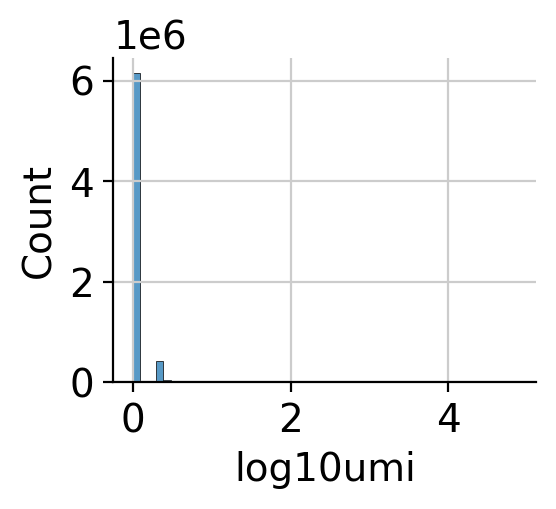

In [11]:
mu.pl.histogram(mdata_raw['rna'], ['log10umi'], bins=50)

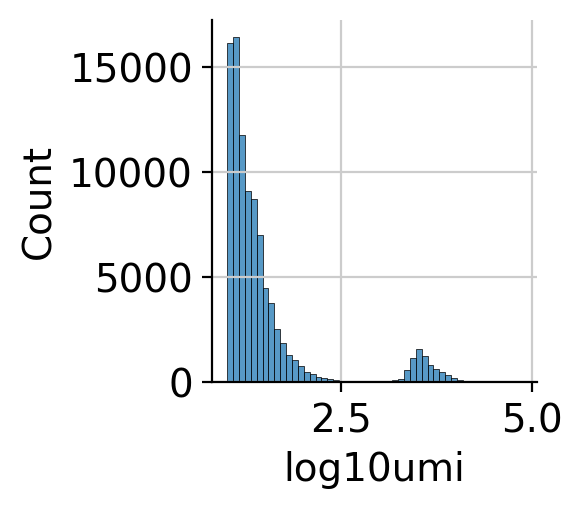

In [12]:
mu.pl.histogram(mdata_raw['rna'][mdata_raw['rna'].obs.log10umi >= 1], ['log10umi'], bins=50)

In [13]:
display(mdata_raw['prot'].var_names)

Index(['CD3', 'CD4', 'CD8a', 'CD14', 'CD15', 'CD16', 'CD56', 'CD19', 'CD25',
       'CD45RA', 'CD45RO', 'PD-1', 'TIGIT', 'CD127', 'IgG2a', 'IgG1', 'IgG2b'],
      dtype='object', name='gene_ids')

In [14]:
isotypes = ['IgG2a', 'IgG1', 'IgG2b']

mu.prot.pp.dsb(mdata, mdata_raw, isotype_controls=isotypes, random_state=1, add_layer=True)
prot.X = prot.layers['dsb']
display(mdata)

/home/svenkatesan/.conda/envs/Shri_NN/lib/python3.12/site-packages/muon/_prot/preproc.py:109: UserWarning: empty_counts_range values are not provided, treating all the non-cells as empty droplets
  warn(


MuData object with n_obs × n_vars = 7865 × 33555
  obs:	'trueType'
  2 modalities
    rna:	7865 x 33538
      var:	'entrezgene_symbol', 'feature_types', 'genome', 'pattern', 'read', 'sequence'
      layers:	'counts'
    prot:	7865 x 17
      var:	'feature_name', 'feature_types', 'genome', 'pattern', 'read', 'sequence'
      layers:	'counts', 'dsb'

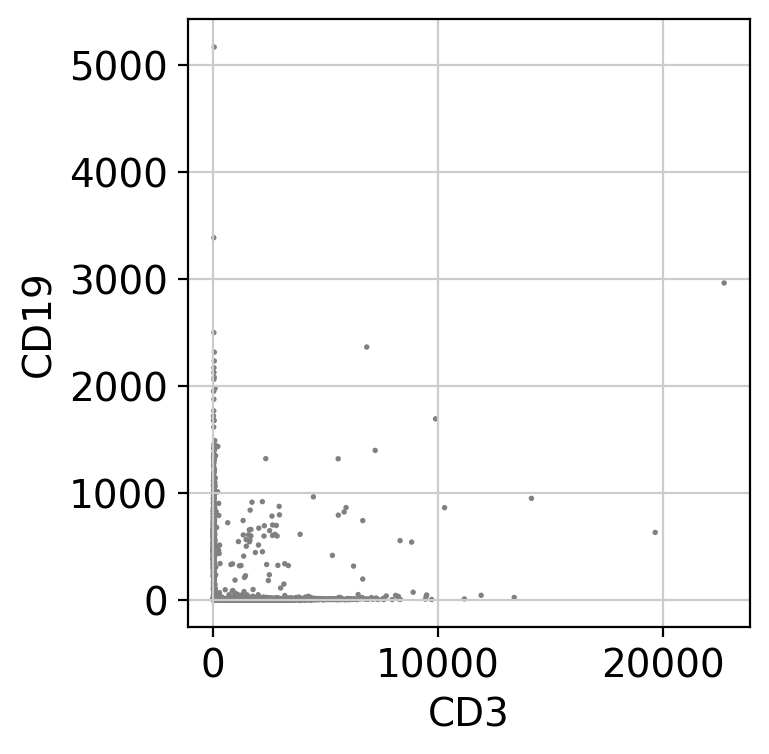

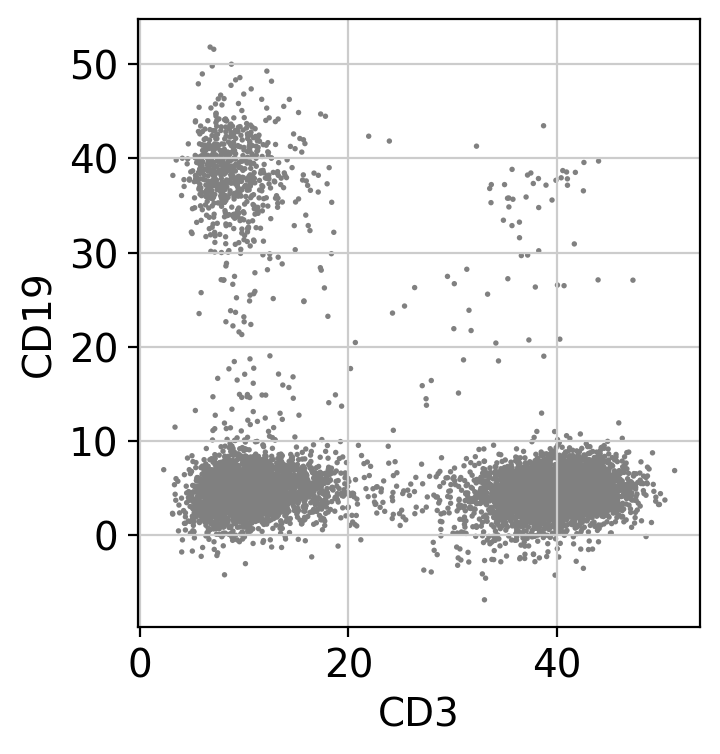

In [15]:
sc.pl.scatter(prot, x="CD3", y="CD19", layers='counts')
sc.pl.scatter(prot, x="CD3", y="CD19", layers='dsb')

In [16]:
sc.tl.pca(prot)
sc.pp.neighbors(prot)
sc.tl.umap(prot)

/tmp/ipykernel_3356476/3235716030.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(prot, resolution=0.2)


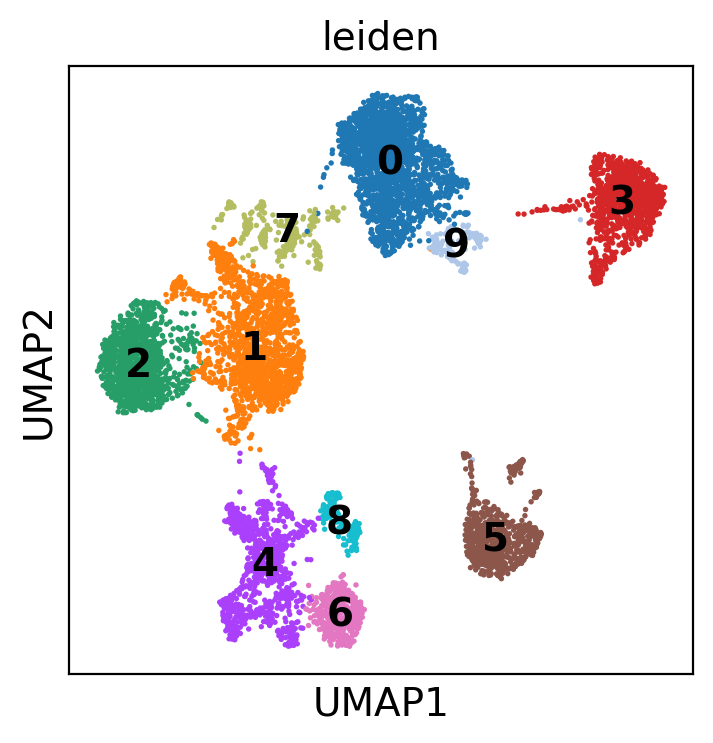

In [17]:
sc.tl.leiden(prot, resolution=0.2)
sc.pl.umap(prot, color='leiden', legend_loc='on data')

## Preprocessing RNA data

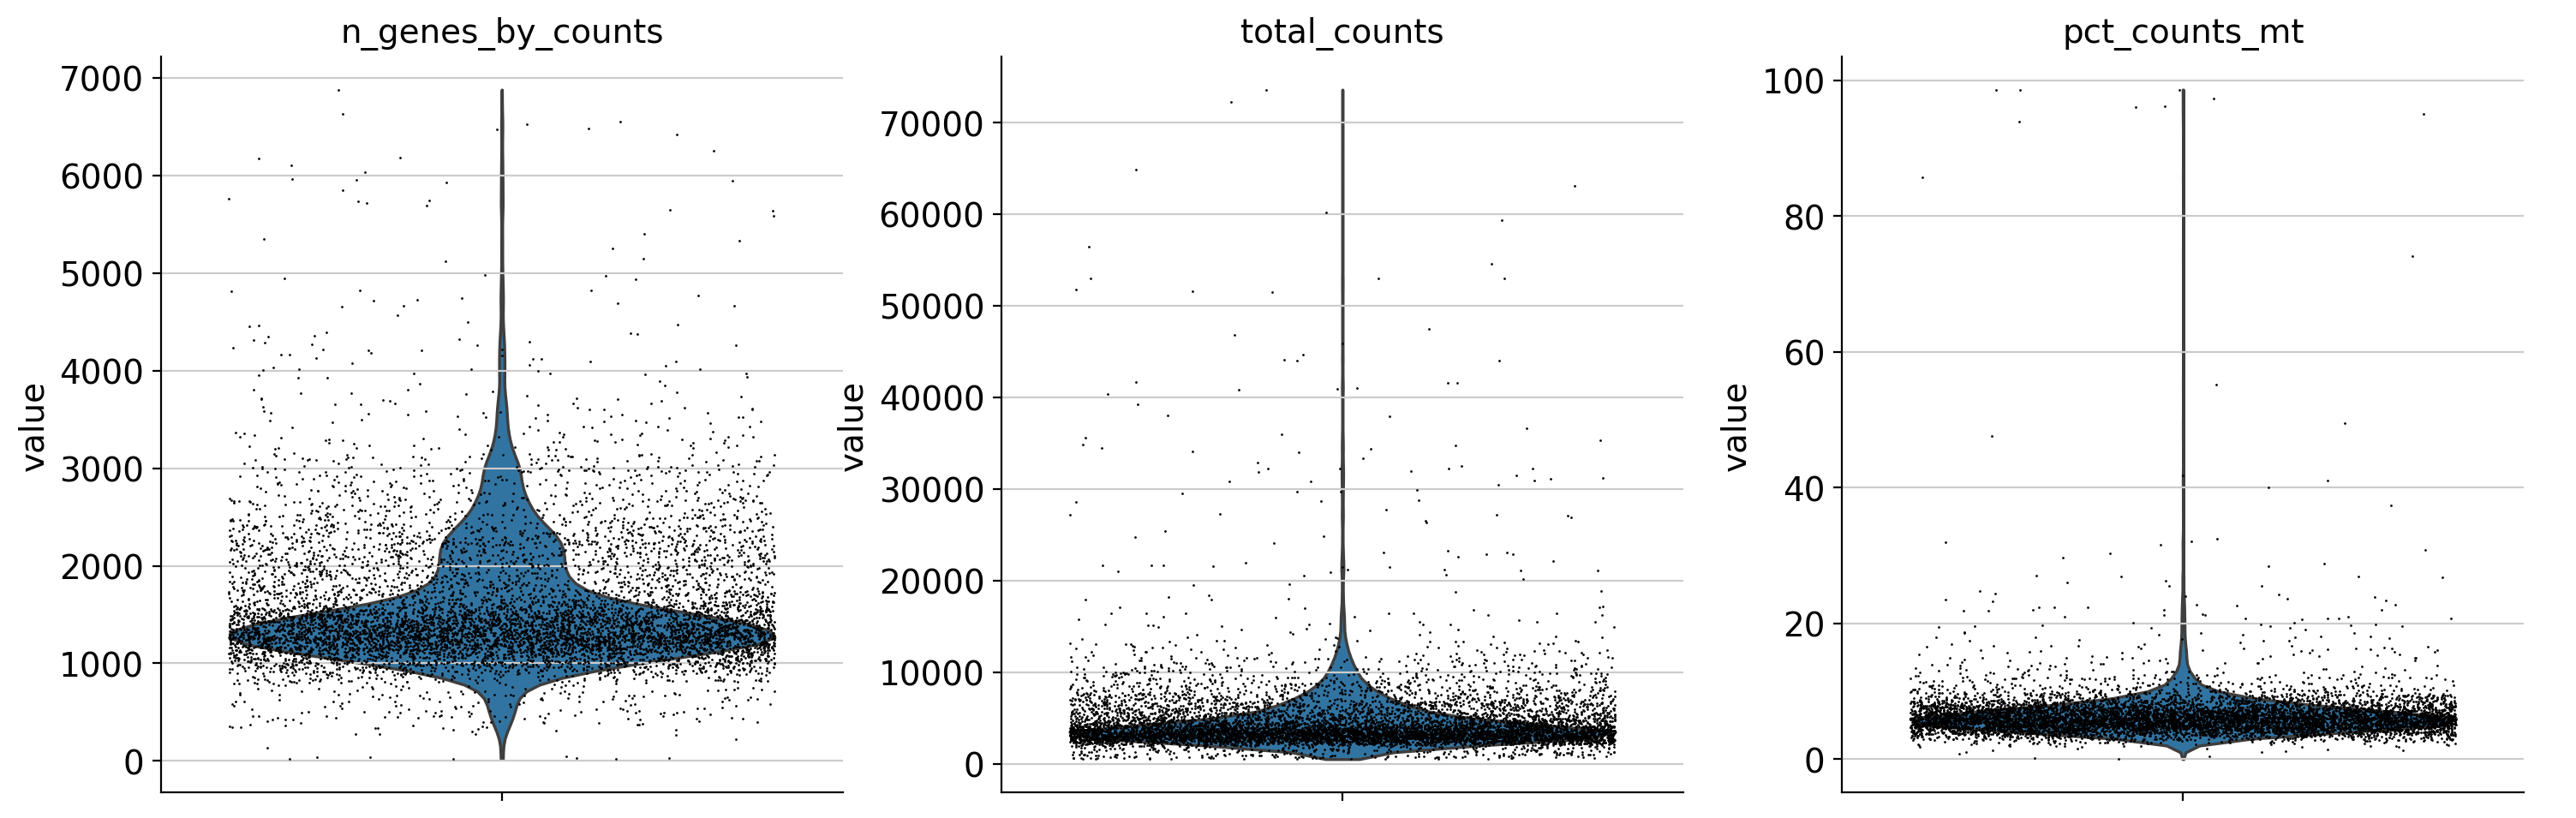

In [18]:
rna.var['mt'] = rna.var['entrezgene_symbol'].str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(rna, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(rna, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)

In [19]:
# mu.pp.filter_var(rna, 'n_cells_by_counts', lambda x: x >= 3)
# mu.pp.filter_obs(rna, 'n_genes_by_counts', lambda x: (x >= 200) & (x < 5000))
# mu.pp.filter_obs(rna, 'total_counts', lambda x: (x > 1500) & (x < 15000))
# mu.pp.filter_obs(rna, 'pct_counts_mt', lambda x: x < 20)
# sc.pl.violin(rna, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)

In [20]:
sc.pp.normalize_total(rna, target_sum=1e4)
sc.pp.log1p(rna)
rna.layers['log_norm'] = rna.X.copy()

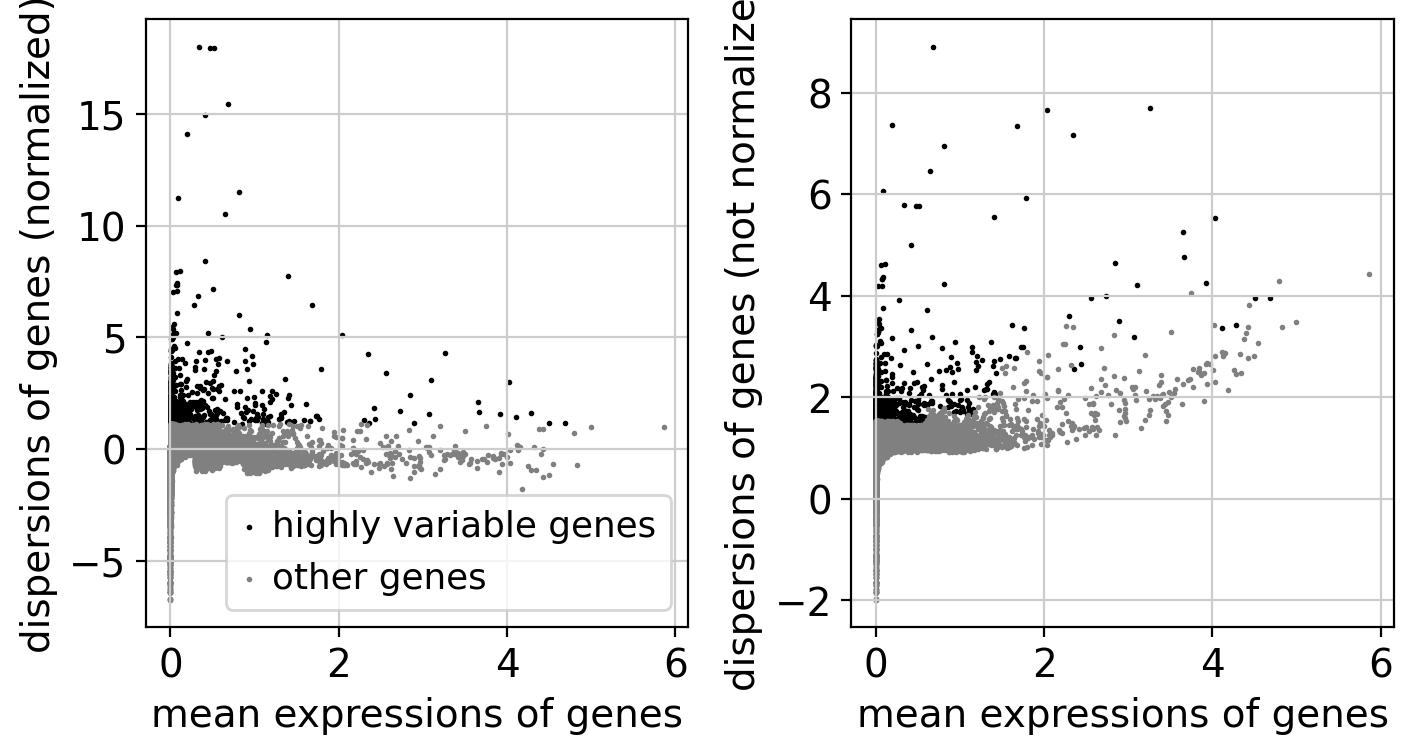

In [21]:
sc.pp.highly_variable_genes(rna, n_top_genes=1000, flavor='seurat', subset=False)
sc.pl.highly_variable_genes(rna)

In [22]:
sc.pp.scale(rna, max_value=10)
rna.layers['zscored'] = rna.X.copy()

/home/svenkatesan/.conda/envs/Shri_NN/lib/python3.12/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


/home/svenkatesan/.conda/envs/Shri_NN/lib/python3.12/site-packages/scanpy/preprocessing/_pca/__init__.py:227: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  mask_var_param, mask_var = _handle_mask_var(


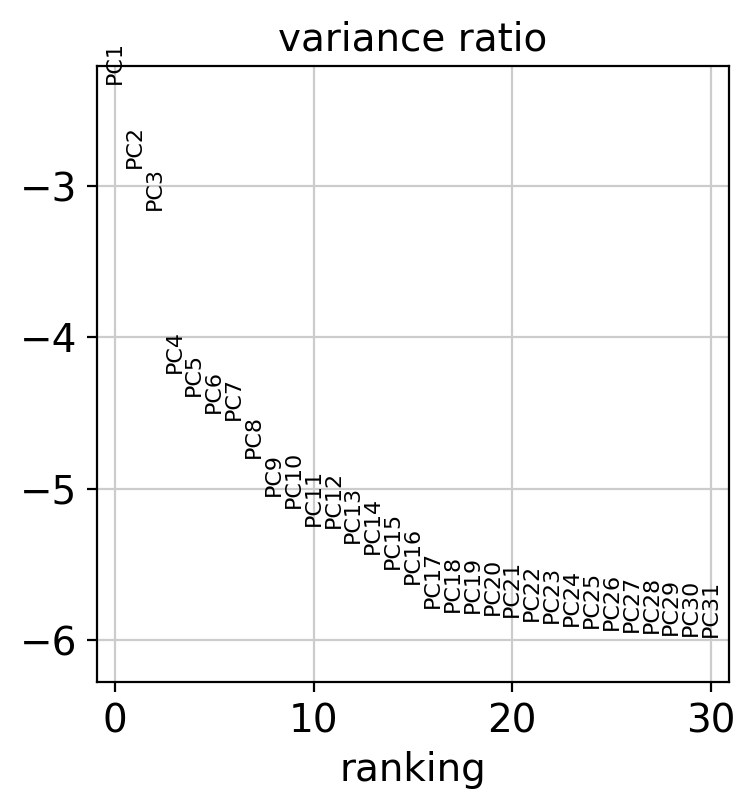

In [23]:
sc.tl.pca(rna, svd_solver='arpack', use_highly_variable=True)
sc.pl.pca_variance_ratio(rna, log=True)

In [24]:
sc.pp.neighbors(rna)
sc.tl.umap(rna)

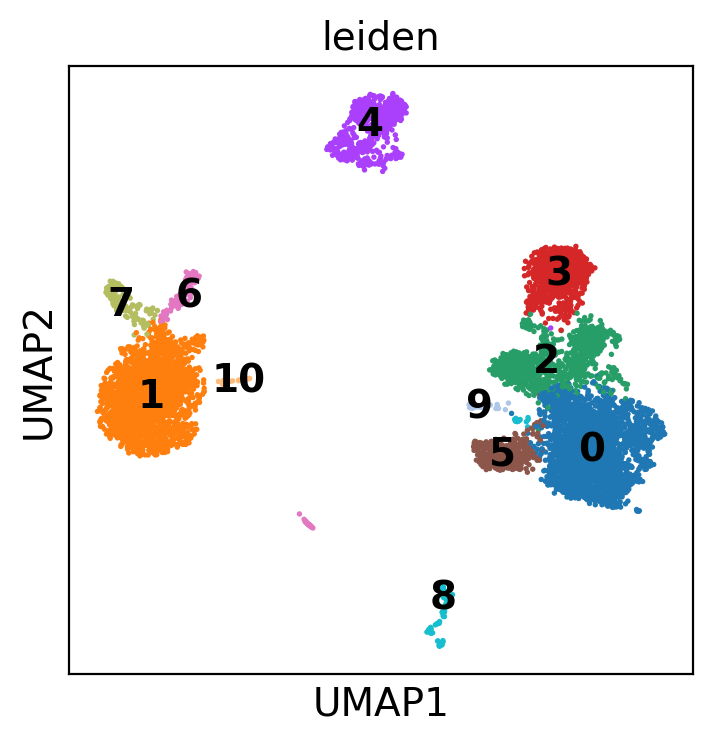

In [25]:
sc.tl.leiden(rna, resolution=0.3)
sc.pl.umap(rna, color='leiden', legend_loc='on data')

## Joint preprocessing

In [26]:
mu.pp.intersect_obs(mdata)
mdata.pull_obs(columns=['leiden'], mods=['rna', 'prot'])
display(mdata)

MuData object with n_obs × n_vars = 7865 × 33555
  obs:	'trueType'
  2 modalities
    rna:	7865 x 33538
      obs:	'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
      var:	'entrezgene_symbol', 'feature_types', 'genome', 'pattern', 'read', 'sequence', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
      uns:	'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      layers:	'counts', 'log_norm', 'zscored'
      obsp:	'distances', 'connectivities'
    prot:	7865 x 17
      obs:	'leiden'
      var:	'feature_name', 'feature_types', 'genome', 'pattern', 'read', 'sequence'
      uns:	'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      layers:	'counts', 'dsb'
      obsp:	'distances', 'connectivities'

In [27]:
mu.tl.leiden(mdata, resolution=0.4, key_added='joint_leiden')
mdata.push_obs(columns=['joint_leiden', 'trueType'])

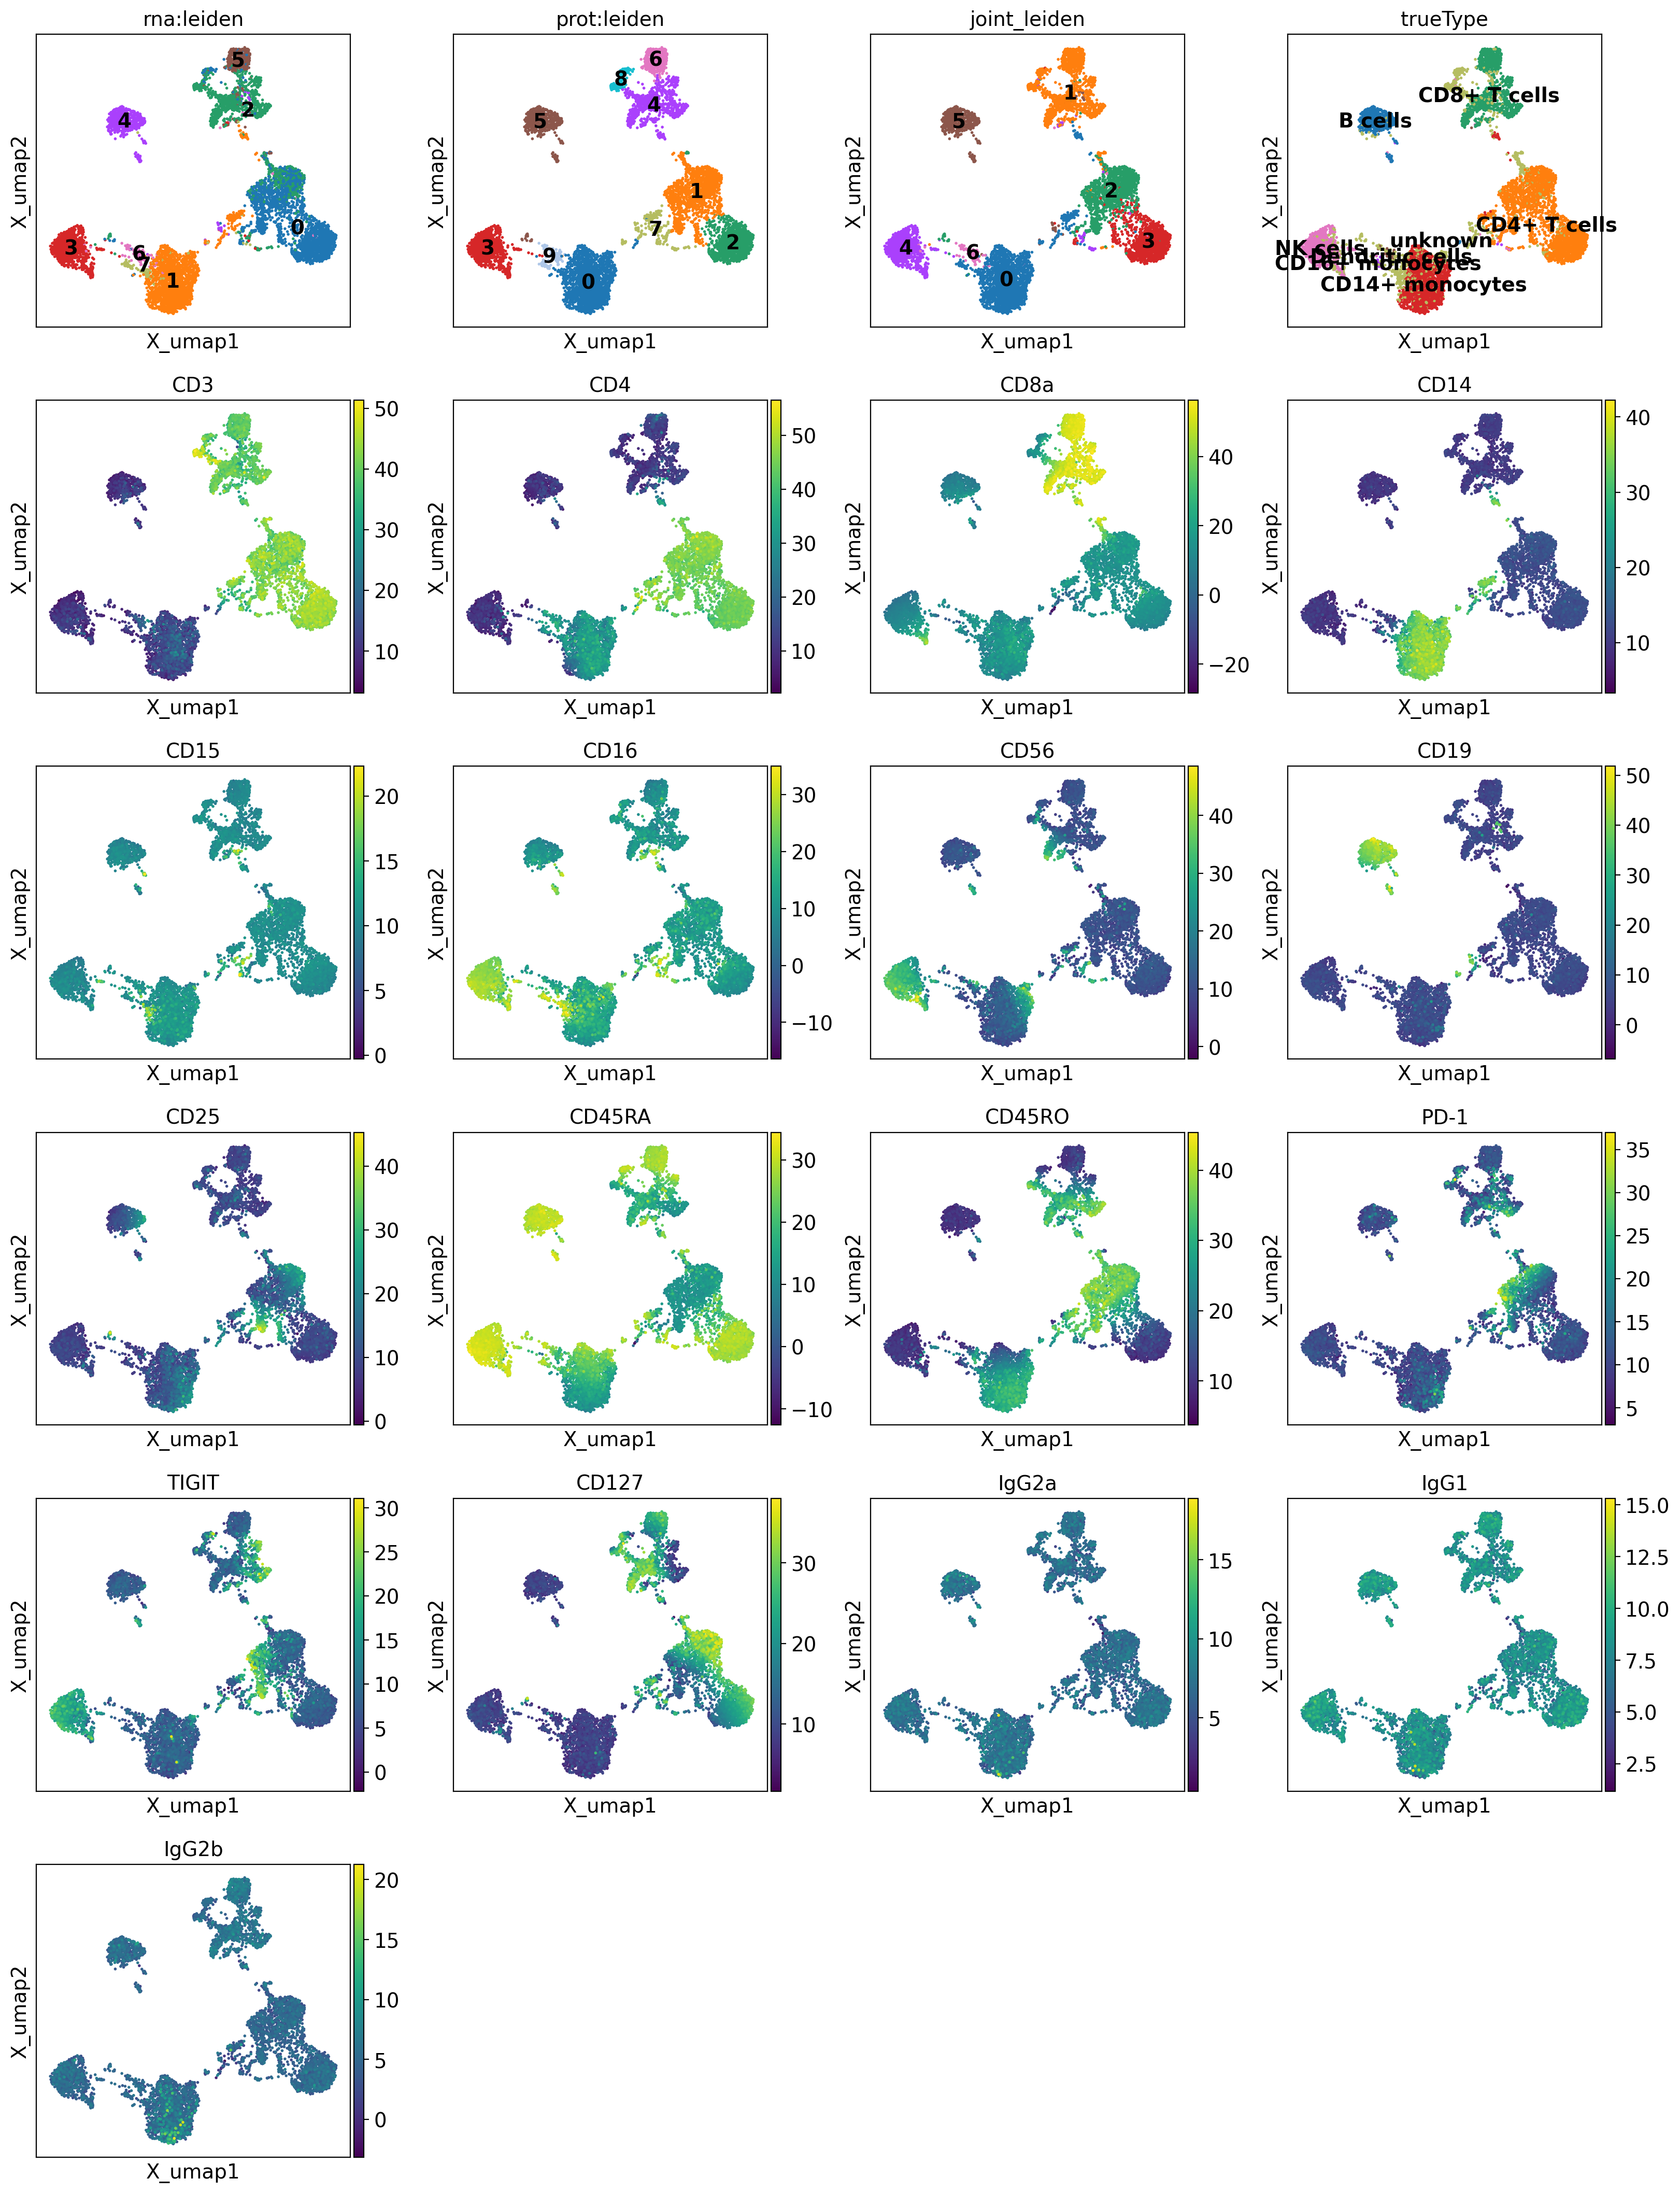

In [28]:
ax = mu.pl.embedding(mdata, basis='prot:X_umap',
                     color=["rna:leiden", "prot:leiden", "joint_leiden", "trueType"]+mdata.mod['prot'].var_names.tolist(),
                     return_fig=True, legend_loc='on data', color_map='viridis')

In [29]:
rna.obs['joint_leiden'] = rna.obs['joint_leiden'].cat.remove_unused_categories()
prot.obs['joint_leiden'] = prot.obs['joint_leiden'].cat.remove_unused_categories()

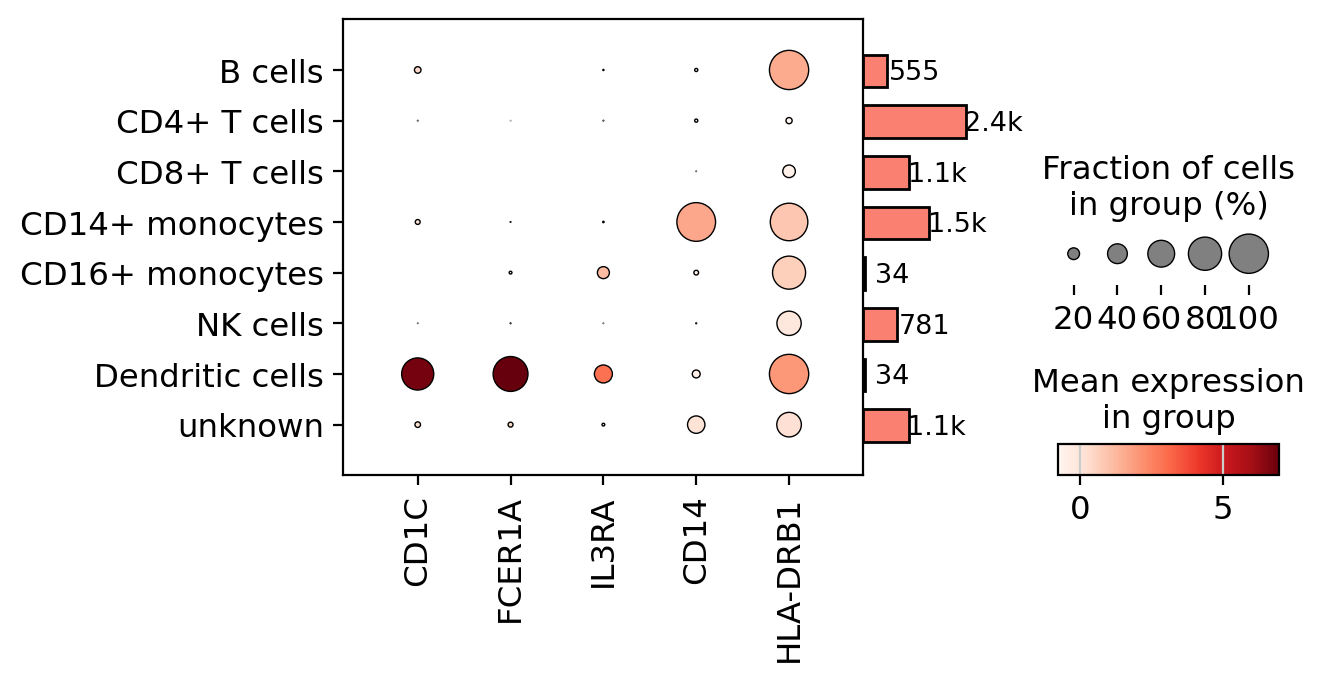

In [30]:
dp = sc.pl.dotplot(rna, var_names=['CD1C', 'FCER1A', 'IL3RA', 'CD14', 'HLA-DRB1'], groupby='trueType', gene_symbols='entrezgene_symbol', dendrogram=False, return_fig=True,
                   categories_order=['B cells', 'CD4+ T cells', 'CD8+ T cells',
                                     'CD14+ monocytes', 'CD16+ monocytes', 'NK cells',
                                     'Dendritic cells', 'unknown'], figsize=(6, 3))
dp.add_totals().style(dot_edge_color='black', dot_edge_lw=0.5).show()

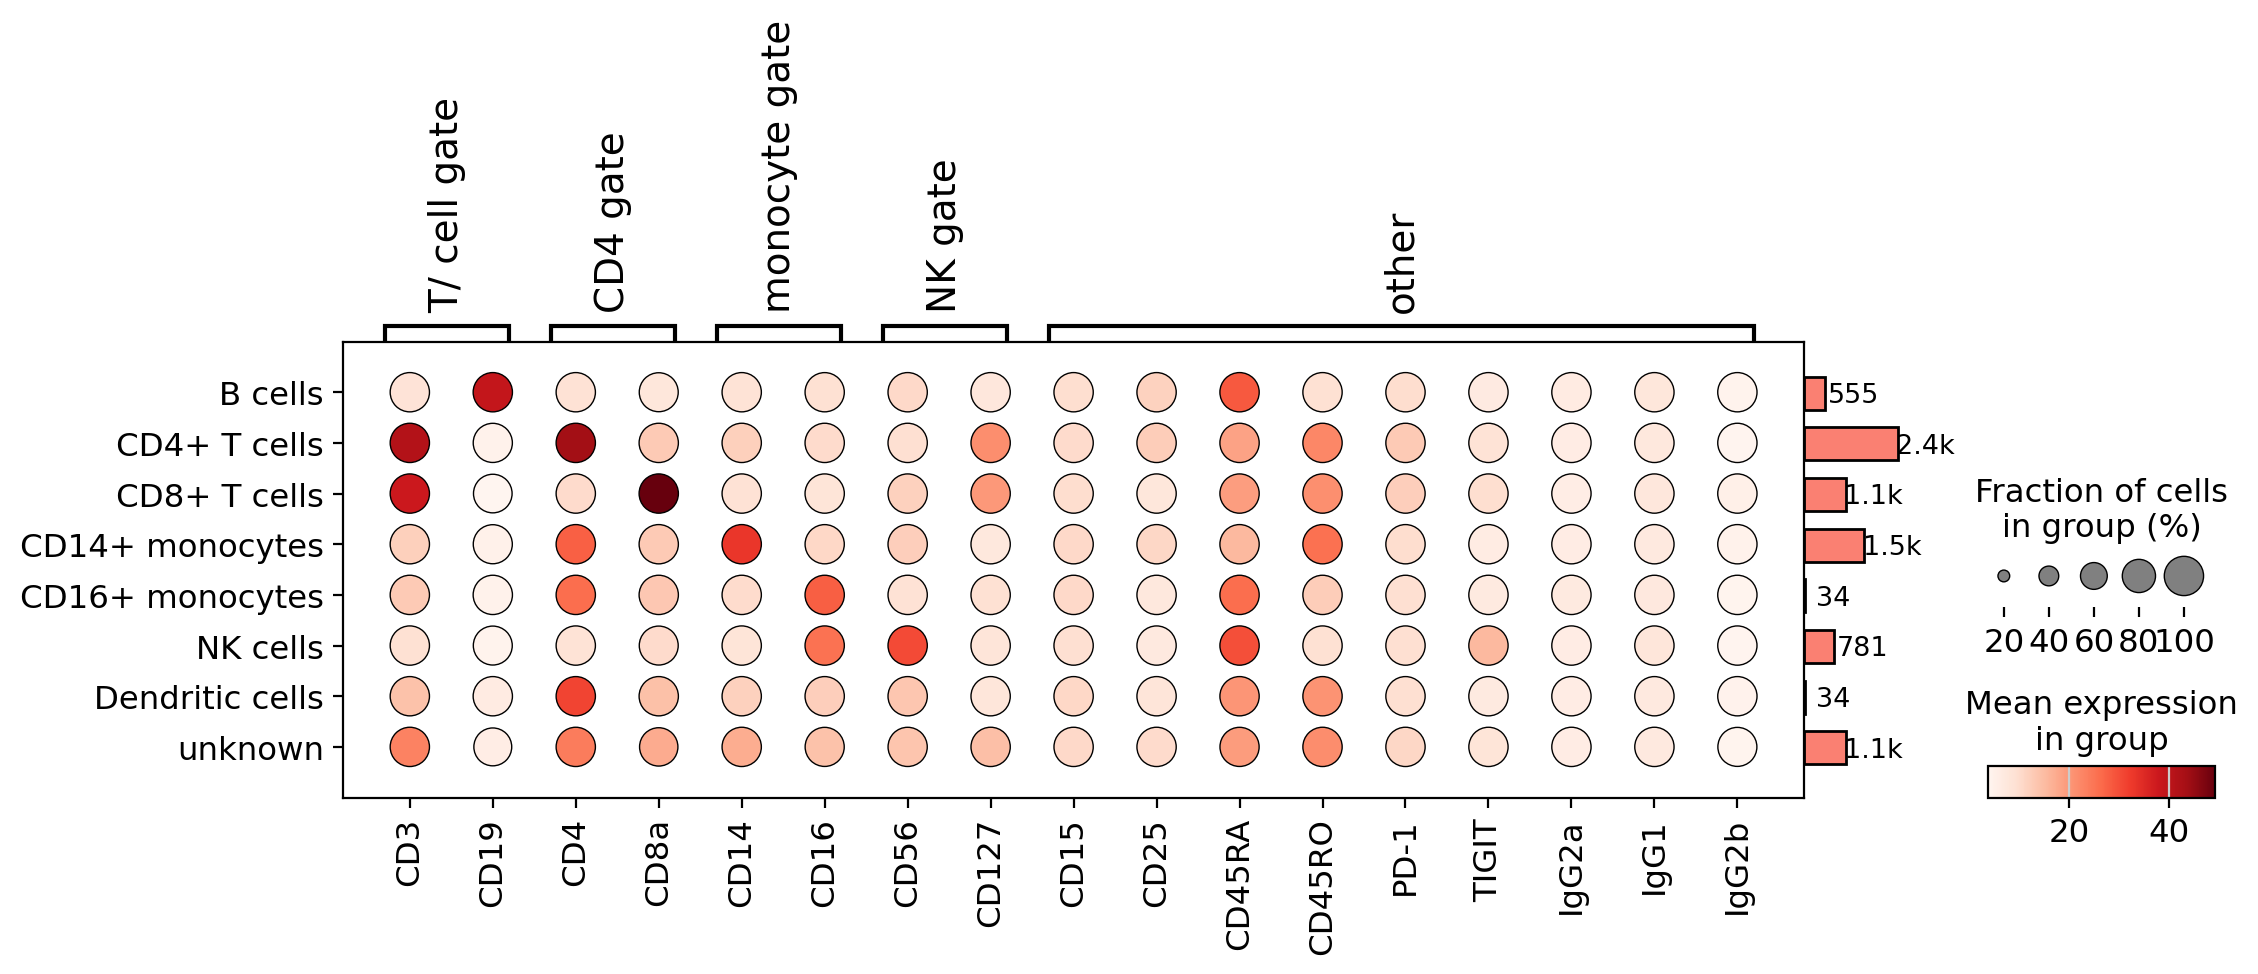

In [35]:
dp = sc.pl.dotplot(prot, var_names={'T/ cell gate': ['CD3', 'CD19'],
                                    'CD4 gate': ['CD4', 'CD8a'],
                                    'monocyte gate': ['CD14', 'CD16'],
                                    'NK gate': ['CD56', 'CD127'],
                                    'other': ['CD15', 'CD25', 'CD45RA', 'CD45RO', 'PD-1', 'TIGIT', 'IgG2a', 'IgG1', 'IgG2b']},
                   groupby='trueType', dendrogram=False, return_fig=True,
                   categories_order=['B cells', 'CD4+ T cells', 'CD8+ T cells',
                                     'CD14+ monocytes', 'CD16+ monocytes', 'NK cells',
                                     'Dendritic cells', 'unknown'], figsize=(12, 3))
dp.add_totals().style(dot_edge_color='black', dot_edge_lw=0.5).show()

## Save mdata

In [47]:
mdata.write(os.path.join(processedDir, '10x_pbmc_10k_protein', "10xpbmc_10k_protein_processed.h5mu"))

In [48]:
display(mdata)

MuData object with n_obs × n_vars = 7501 × 18071
  obs:	'trueType', 'joint_leiden'
  uns:	'leiden'
  2 modalities
    rna:	7501 x 18054
      obs:	'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'joint_leiden', 'trueType'
      var:	'entrezgene_symbol', 'feature_types', 'genome', 'pattern', 'read', 'sequence', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
      uns:	'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      layers:	'counts', 'log_norm', 'zscored'
      obsp:	'distances', 'connectivities'
    prot:	7501 x 17
      obs:	'leiden', 'joint_leiden', 'trueType'
      var:	'feature_name', 'feature_types', 'genome', 'pattern', 'read', 'sequence'
      uns:	'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'rna:leiden_colors', 'prot:leiden_colors', 'joint_leiden_colors', 'trueType_colors'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      layers:	'counts', 'dsb'
      obsp:	'distances', 'connectivities'